In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
from tools import *
from CONSTANT import *
import gc

signals = ['BVP', 'EDA', 'HR', 'TEMP']

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# pd.set_option("display.max_info_columns", 1300)

import gc

%matplotlib inline

In [2]:
wesad_path = r'./WESAD/WESAD/'
ppg_path = r'./PPGFieldStudyDataset/PPG_FieldStudy/'

In [4]:
# def extract_E4zip(folderpath):
#     for root, dir, files in os.walk(folderpath):
#         for file in files:
#             if '.zip' not in file and 'E4' not in file:
#                 continue
#             filename = os.path.join(root, file)
#             with zipfile.ZipFile(filename,"r") as zip_ref:
#                 zip_ref.extractall(filename.replace('.zip',''))
#     print(filename, 'done')

In [5]:
# extract_E4zip(wesad_path)
# extract_E4zip(ppg_path)

# get label

In [3]:
# label_file = r'./WESAD/WESAD/S10/S10_quest.csv'

def get_label(quest_file):
    labels = pd.read_csv(quest_file)
    conditions = labels.loc[0].values[0].replace('# ORDER;', '').replace(';bRead;fRead;sRead;;;;;;;;;;;;;;;;;;', '').split(';')
    starts = [float(t) * 60 for t in labels.iloc[1].values[0].split(';')[1:6]]
    ends = [float(t) * 60 for t in labels.iloc[2].values[0].split(';')[1:6]]
    va = [sc[0].replace('# DIM;', '')[:3].split(';') for sc in labels.iloc[16: 21].values]
    valence = [float(sc[0]) for sc in va]
    arousal = [float(sc[1]) for sc in va]
    return conditions, starts, ends, valence, arousal


In [4]:
def signal_process(signal_name, raw_signal, valence, arousal, starts, ends, subject, conditions, win_size=4, step = 2):
    
    if signal_name == 'HR':
        raw_signal = raw_signal.iloc[2:, 0].values
    else:
        raw_signal = raw_signal.iloc[2+SAMPLERATE[signal_name]*10:, 0].values
    base_condition = raw_signal[int(starts[0]*SAMPLERATE[signal_name]): int(ends[0]*SAMPLERATE[signal_name])+1]
    baseline = base_condition.mean()

    signal_df = []
    
    for i in range(1, 5):
        condition_signal = raw_signal[int(starts[i]*SAMPLERATE[signal_name]): int(ends[i]*SAMPLERATE[signal_name])+1]
        # if i == 0:
        #     condition_signal = raw_signal
        # else:
        condition_signal = condition_signal - baseline
        signal = (condition_signal - condition_signal.min()) / (condition_signal.max() - condition_signal.min())
        condition = conditions[i]

        if signal_name == 'EDA':
            signal = butter_lowpass_filter(signal, cutOff=CUTOFF['EDA'], fs=SAMPLERATE['EDA'])
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE['EDA'], output_fs=100)
        elif signal_name in ['TEMP', 'BVP']:
            signal = butter_bandpass_filter(signal, lowcut=CUTOFF[signal_name][0], highcut=CUTOFF[signal_name][1], fs=SAMPLERATE[signal_name])
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
        elif signal_name == 'HR':
            # signal = chauvenet_filter(signal)
            # print(signal)
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
        else:
            pass

        segments = np.array(segment_generator(signal, win_size=win_size*100, step=step*100))
        seg_cols = ['{}_seg{}'.format(signal_name, i) for i in range(segments.shape[1])]
        segment_df = pd.DataFrame(columns=seg_cols, data=segments)

        segment_df['segment_id'] = segment_df.index.tolist()
        segment_df['condition'] = condition
        segment_df['valence_rating'] = valence[i]
        segment_df['arousal_rating'] = arousal[i]
        segment_df['participant_id'] = subject

        signal_df.append(segment_df)
    return pd.concat(signal_df)

In [5]:
subjects = ['S6', 'S9', 'S2', 'S13', 'S11', 'S10', 'S8', 'S14',
            'S15', 'S5', 'S17', 'S16', 'S3', 'S7', 'S4']

valences = []
arousals = []

all_signals_df = []


for subject in subjects:
      quest_file = os.path.join(wesad_path, subject, '{}_quest.csv'.format(subject))
      conditions, starts, ends, valence, arousal = get_label(quest_file)
      e4_path = os.path.join(wesad_path, subject, '{}_E4_Data'.format(subject))
      valences.extend(valence)
      arousals.extend(arousal)

      hr_signal = pd.read_csv(os.path.join(e4_path, '{}.csv'.format('HR')))
      eda_signal = pd.read_csv(os.path.join(e4_path, '{}.csv'.format('EDA')))
      bvp_signal = pd.read_csv(os.path.join(e4_path, '{}.csv'.format('BVP')))
      temp_signal = pd.read_csv(os.path.join(e4_path, '{}.csv'.format('TEMP')))

      # hr_signal_ts = hr_signal.columns.tolist()[0]
      # eda_signal_ts = eda_signal.columns.tolist()[0]
      # temp_signal_ts = temp_signal.columns.tolist()[0]
      # bvp_signal_ts = bvp_signal.columns.tolist()[0]
      # print(hr_signal_ts, eda_signal_ts, temp_signal_ts, bvp_signal_ts)

      hr_df = signal_process('HR', hr_signal, valence, arousal, starts, ends, subject, conditions, win_size=4, step = 2)
      eda_df = signal_process('EDA', eda_signal, valence, arousal, starts, ends, subject, conditions, win_size=4, step = 2)
      temp_df = signal_process('TEMP', temp_signal, valence, arousal, starts, ends, subject, conditions, win_size=4, step = 2)
      bvp_df = signal_process('BVP', bvp_signal, valence, arousal, starts, ends, subject, conditions, win_size=4, step = 2)

      # condition_shap = {'TSST': float('inf'), 'Medi 1': float('inf'), 'Medi 2': float('inf'), 'Fun': float('inf')}
      condition_shap = {}

      for cond in ['TSST', 'Medi 1', 'Medi 2', 'Fun']:
            condition_shap[cond] = min(hr_df['condition'].value_counts().to_dict()[cond], 
            eda_df['condition'].value_counts().to_dict()[cond],
            temp_df['condition'].value_counts().to_dict()[cond],
            bvp_df['condition'].value_counts().to_dict()[cond]
            )

      def reshape_df(df):
            dfs = []
            for cond in condition_shap.keys():
                  dfs.append(df[df['condition']==cond].iloc[:condition_shap[cond]])
            return pd.concat(dfs)

      hr_df = reshape_df(hr_df)
      eda_df = reshape_df(eda_df)
      temp_df = reshape_df(temp_df)
      bvp_df = reshape_df(bvp_df)

      bvp_eda_df = bvp_df.merge(eda_df, on=['segment_id', 'condition', 'valence_rating', 'arousal_rating', 'participant_id'], how='left')
      bvp_eda_hr_df = bvp_eda_df.merge(hr_df, on=['segment_id', 'condition', 'valence_rating', 'arousal_rating', 'participant_id'], how='left')
      bvp_eda_hr_temp_df = bvp_eda_hr_df.merge(temp_df, on=['segment_id', 'condition', 'valence_rating', 'arousal_rating', 'participant_id'], how='left')

      del bvp_eda_hr_temp_df['segment_id']

      # print(bvp_eda_hr_temp_df.isnull().sum().sum(), bvp_eda_hr_temp_df.shape)

      all_signals_df.append(bvp_eda_hr_temp_df)

      # bvp_eda_hr_temp_df = reduce_mem_usage(bvp_eda_hr_temp_df, un_process=['segment_id', 'participant_id', 'condition'])
      # gc.collect()

      # print(hr_df.shape, eda_df.shape, temp_df.shape, bvp_df.shape)


      # print(hr_df['condition'].value_counts().to_dict(), 
      #       eda_df['condition'].value_counts().to_dict(), 
      #       temp_df['condition'].value_counts().to_dict(), 
      #       bvp_df['condition'].value_counts().to_dict())
      # print()

      # break

all_signals_df = pd.concat(all_signals_df)
all_signals_df = reduce_mem_usage(all_signals_df, un_process=['participant_id'])
gc.collect()

Mem. usage decreased to 43.58 Mb (74.9% reduction)
Final (14158, 1604)


0

In [6]:
all_signals_df['arousal'] = all_signals_df['arousal_rating'].astype(float)
all_signals_df['valence'] = all_signals_df['valence_rating'].astype(float)

/home/alan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.
/home/alan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [7]:
all_signals_df.isnull().sum().sum()

0

In [8]:
all_signals_df.describe()

,BVP_seg0,BVP_seg1,BVP_seg2,BVP_seg3,BVP_seg4,BVP_seg5,BVP_seg6,BVP_seg7,BVP_seg8,BVP_seg9,...,TEMP_seg392,TEMP_seg393,TEMP_seg394,TEMP_seg395,TEMP_seg396,TEMP_seg397,TEMP_seg398,TEMP_seg399,arousal,valence
count,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,...,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000,14158.000000
mean,0.000140,0.000216,0.000334,0.000504,0.000747,0.000998,0.001238,0.001383,0.001458,0.001378,...,-0.000580,-0.000582,-0.000583,-0.000585,-0.000587,-0.000588,-0.000590,-0.000591,4.080520,5.981565
std,0.036041,0.035950,0.036102,0.036377,0.036957,0.038025,0.039307,0.040100,0.040680,0.040009,...,0.110840,0.110840,0.110840,0.110840,0.110840,0.110840,0.110840,0.110840,2.608014,1.805437
min,-0.322754,-0.327393,-0.323975,-0.349365,-0.370605,-0.387939,-0.398193,-0.402588,-0.403809,-0.437988,...,-0.387695,-0.387695,-0.387695,-0.387695,-0.387695,-0.387695,-0.387695,-0.387695,1.000000,1.000000
25%,-0.012657,-0.012640,-0.012566,-0.012512,-0.012428,-0.012390,-0.012436,-0.012367,-0.012327,-0.012350,...,-0.046135,-0.046135,-0.046135,-0.046074,-0.046051,-0.046021,-0.046021,-0.046074,2.000000,5.000000
50%,0.000138,0.000171,0.000132,0.000154,0.000157,0.000134,0.000098,0.000188,0.000238,0.000272,...,-0.000034,0.000000,0.000009,0.000017,0.000038,0.000024,0.000015,0.000019,3.000000,6.000000
75%,0.012032,0.012373,0.012419,0.012367,0.012505,0.012686,0.012611,0.012548,0.012619,0.012869,...,0.044525,0.044556,0.044586,0.044609,0.044548,0.044609,0.044617,0.044640,7.000000,7.000000
max,0.450439,0.406982,0.408691,0.410156,0.385498,0.409180,0.422607,0.430420,0.433105,0.427246,...,0.795898,0.795898,0.795410,0.795410,0.795410,0.794922,0.794922,0.794922,9.000000,9.000000


In [10]:
all_signals_df.to_pickle(r'./processed_signal/WESAD/400_4s_step_2s.pkl')

# generating train_test spliter

In [5]:
all_signals_df = pd.read_pickle(r'./processed_signal/WESAD/400_4s_step_2s.pkl')

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold

feature_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in SIGNALS]
target_cols = ['arousal_rating', 'valence_rating']
group_cols = ['participant_id', 'condition']

spliter = {'cv': [], 'loso': [], 'loao': []}

In [7]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=31)
for train_index, test_index in skf.split(all_signals_df[feature_cols], all_signals_df['valence_rating']):
    spliter['cv'].append({'train_index': train_index, 'test_index': test_index})

loso_skgf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=31)
for train_index, test_index in loso_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_rating'], groups=all_signals_df['participant_id']):
    spliter['loso'].append({'train_index': train_index, 'test_index': test_index})

loao_skgf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=31)
for train_index, test_index in loao_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_rating'], groups=all_signals_df['condition']):
    spliter['loao'].append({'train_index': train_index, 'test_index': test_index})

In [8]:
save_model(r'./processed_signal/WESAD/400_4s_step_2s_spliter10.pkl', spliter)
print(len(spliter['loso'][0]['train_index']), len(spliter['loso'][0]['test_index']))
print(len(spliter['loao'][0]['train_index']), len(spliter['loao'][0]['test_index']))
print(len(spliter['cv'][0]['train_index']), len(spliter['cv'][0]['test_index']))

./processed_signal/WESAD/400_4s_step_2s_spliter10.pkl saved done!
13236 922
11070 3088
12742 1416


# get determine threshold

array([5.53387741, 4.9244803 ])

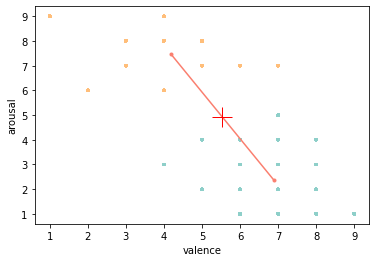

In [22]:
av_rating = pd.DataFrame()
av_rating['valence_rating'] = all_signals_df['valence_rating']
av_rating['arousal_rating'] = all_signals_df['arousal_rating']

colors = ["#8ECFC9", "#FF9C34", "#4E9A06"]

kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[['valence_rating', 'arousal_rating']])
plt.scatter(y=av_rating['arousal_rating'], x=av_rating['valence_rating'], 
            facecolors='none', edgecolors=['#8ECFC9' if i==0 else '#FFBE7A' for i in kmeans.labels_ ], s=4)
plt.ylabel('arousal')
plt.xlabel('valence')
plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='#FA7F6F', marker="o", markersize=3)
threshold = kmeans.cluster_centers_.sum(axis=0)/2
plt.plot(threshold[0], threshold[1], c='red', marker="+", markersize=20)
kmeans.cluster_centers_.sum(axis=0)/2

In [23]:
midpoint = kmeans.cluster_centers_.sum(axis=0)/2
av_rating['valence_label'] = av_rating['valence_rating'].apply(lambda x: 1 if x>midpoint[0] else 0)
av_rating['arousal_label'] = av_rating['arousal_rating'].apply(lambda x: 1 if x>midpoint[1] else 0)
av_rating.head()

,valence_rating,arousal_rating,valence_label,arousal_label
0,6.0,3.0,1,0
1,6.0,3.0,1,0
2,6.0,3.0,1,0
3,6.0,3.0,1,0
4,6.0,3.0,1,0


In [24]:
av_rating['valence_label'].value_counts()

1    9325
0    4833
Name: valence_label, dtype: int64

In [26]:
av_rating['arousal_label'].value_counts()

0    9235
1    4923
Name: arousal_label, dtype: int64

array([5.56666667, 4.89166667])

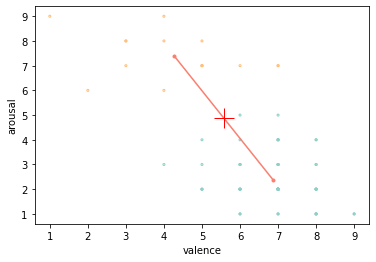

In [17]:
av_rating = pd.DataFrame()
av_rating['valence_rating'] = valences
av_rating['arousal_rating'] = arousals

colors = ["#8ECFC9", "#FF9C34", "#4E9A06"]

kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[['valence_rating', 'arousal_rating']])
plt.scatter(y=av_rating['arousal_rating'], x=av_rating['valence_rating'], 
            facecolors='none', edgecolors=['#8ECFC9' if i==0 else '#FFBE7A' for i in kmeans.labels_ ], s=4)
plt.ylabel('arousal')
plt.xlabel('valence')
plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='#FA7F6F', marker="o", markersize=3)
threshold = kmeans.cluster_centers_.sum(axis=0)/2
plt.plot(threshold[0], threshold[1], c='red', marker="+", markersize=20)
kmeans.cluster_centers_.sum(axis=0)/2

In [18]:
midpoint = kmeans.cluster_centers_.sum(axis=0)/2
av_rating['valence_label'] = av_rating['valence_rating'].apply(lambda x: 1 if x>midpoint[0] else 0)
av_rating['arousal_label'] = av_rating['arousal_rating'].apply(lambda x: 1 if x>midpoint[1] else 0)
av_rating.head()

,valence_rating,arousal_rating,valence_label,arousal_label
0,8.0,2.0,1,0
1,6.0,3.0,1,0
2,6.0,2.0,1,0
3,8.0,2.0,1,0
4,8.0,1.0,1,0


In [19]:
av_rating['valence_label'].value_counts()

1    57
0    18
Name: valence_label, dtype: int64

In [20]:
av_rating['valence_rating'].value_counts()

7.0    27
8.0    14
6.0    14
5.0     9
4.0     4
3.0     3
9.0     2
2.0     1
1.0     1
Name: valence_rating, dtype: int64

In [43]:
av_rating['arousal_label'].value_counts()

0    58
1    17
Name: arousal_label, dtype: int64

# get E4

In [13]:
eda_file = r'./WESAD/WESAD/S10/S10_E4_Data/EDA.csv'
eda = pd.read_csv(eda_file)

In [14]:
eda_raw_signal = eda.iloc[2:].values

In [15]:
len(eda_raw_signal)

27287

# parse pkl

In [6]:
pkl_path = r'./WESAD/WESAD/S10/S10.pkl'

with open(pkl_path, 'rb') as file:
    s10_data = pickle.load(file, encoding='latin1')

In [10]:
len(s10_data['label'])

3847200